In [ ]:
# import relevant libraries

import pandas as pd
import numpy as np
import cv2
import os
import sklearn
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, roc_auc_score, average_precision_score, mean_squared_error
import random
from google.colab import drive
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import math

##Dataset

In [ ]:
# load the datasets
!tar -xvf'.../test_set.tar'
!tar -xvf '.../train_and_val_set.tar'

In [ ]:
# a function to create a dataset such that each image is saved with its corresponding labels 

class ImageDataset(Dataset):
    def __init__(self, img_folder, label_folder, transform=None):
        self.img_folder = img_folder
        self.label_folder = label_folder
        self.transform = transform
        self.img_files = os.listdir(img_folder)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_files[idx])
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Load annotations
        label_valence_file = os.path.join(self.label_folder, f"{os.path.splitext(self.img_files[idx])[0]}_val.npy")
        label_arousal_file = os.path.join(self.label_folder, f"{os.path.splitext(self.img_files[idx])[0]}_aro.npy")
        label_expr_file = os.path.join(self.label_folder, f"{os.path.splitext(self.img_files[idx])[0]}_exp.npy")

        label_valence = np.load(label_valence_file)
        label_arousal = np.load(label_arousal_file)
        label_expr = np.load(label_expr_file)

        label = {'valence': label_valence, 'arousal': label_arousal, 'expression': label_expr}

        return img, label

In [ ]:
# 2 transform functions
# a simple transform that will be applied to every element in each dataset
# a second aug_transform that will be used for data augmentation on the train set

aug_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=10),
    ], p=0.5)
])

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [ ]:
# Create datasets
dataset = ImageDataset(img_folder='/content/train_set/images', label_folder='/content/train_set/annotations', transform=transform)
val_dataset = ImageDataset(img_folder='/content/val_set/images', label_folder='/content/val_set/annotations', transform=transform)

In [ ]:
# split the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
# apply aug_transform to the train set only
train_dataset.dataset.transform = aug_transform

In [ ]:
# redefine the collate_fn function for the dataloader as per the dataset
def collate_fn(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    data = torch.stack(data, 0)
    return [data, target]

In [ ]:
# Load the train and validate datasets to the dataloader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True)

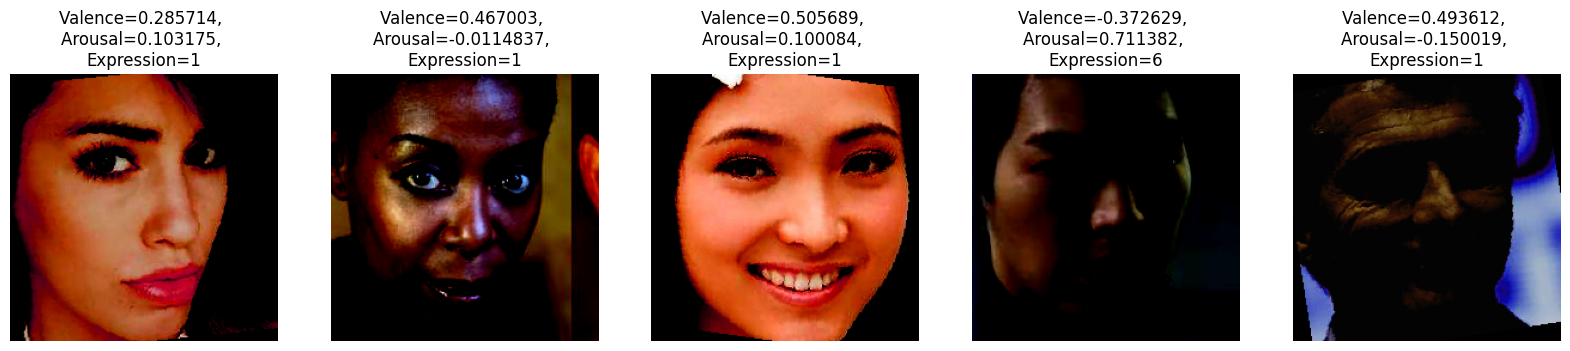

In [ ]:
# Visualise some of the images in the dataset with its labels

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
indices = np.random.choice(range(len(dataset)), size=5, replace=False)
for i, ax in zip(indices, axes):
    img, labels = dataset[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Valence={labels['valence']}, \nArousal={labels['arousal']}, \nExpression={labels['expression']}")
    ax.axis('off')
plt.show()

##Model

In [ ]:
# install the efficientnet

!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=8d30f4dd1defaaa1430fc5e7678ca97ee7e46433188a381a3a5cc301c504ca4f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
# load the B1 version of Efficient Net With the Pretrained weights

from efficientnet_pytorch import EfficientNet
effnet = EfficientNet.from_pretrained('efficientnet-b1')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 87.5MB/s]

Loaded pretrained weights for efficientnet-b1


In [ ]:
effnet

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
# Freeze the parameters of the last fully connected layer
for param in effnet._fc.parameters():
    param.requires_grad = True

In [ ]:
# A class is defined to create 3 FC layers connected parallely 
# This is because our task is to give 2 regression outputs and 1 classification output

class CustomClassifier(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 1)
        self.fc2 = nn.Linear(in_features, 1)
        self.fc3 = nn.Linear(in_features, 8)

    def forward(self, x):
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        return out1, out2, out3

In [ ]:
# the no of input features to the fc layer of the model
num_ftrs = effnet._fc.in_features

In [ ]:
# replace the FC layer of the model with the CustomClassifier
effnet._fc = CustomClassifier(num_ftrs)

In [ ]:
print('No.of parameters: ', sum(p.numel() for p in effnet.parameters()))

No.of parameters:  6525994


In [ ]:
# save the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
effnet.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

##Training

In [ ]:
# Define loss functions for regression & classification
# Define the optimizer and scheduler
criterion_reg = nn.MSELoss()
criterion_cat = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

In [ ]:
# A function that defines the operations that will happen in one epoch

def run_1_epoch(model, dataloader, optimizer = None, train=False):
    if train:
      model.train()
    else:
      model.eval()
      
    loss_ar = []
    e_preds = []
    e_labs = []
    v_preds = []
    v_labs = []
    a_preds = []
    a_labs = []
    for images, labels in tqdm(dataloader):
        # some necessary preprocessing
        valence_labels = []
        arousal_labels = []
        expr_labels = []
        for i in range(len(labels)):
          valence_labels.append([float(labels[i]['valence'])])
          arousal_labels.append([float(labels[i]['arousal'])])
          expr_labels.append(int(labels[i]['expression']))

        valence_labels = torch.tensor(valence_labels)
        arousal_labels = torch.tensor(arousal_labels)
        expr_labels = torch.tensor(expr_labels)

        valence_labels = (valence_labels).to(device)
        arousal_labels = (arousal_labels).to(device)
        expr_labels = (expr_labels).to(device)
        images = (images).to(device)
        
        if train:
          assert optimizer is not None, "Optimizer must be provided if train=True"
          optimizer.zero_grad()
        
        # run the model
        outputs = model(images)
        
        # Separate the outputs into regression and categorical predictions
        valence_preds, arousal_preds, expr_preds = outputs[0], outputs[1], outputs[2]

        # Calculate loss for regression outputs
        loss_valence = criterion_reg(valence_preds, valence_labels)
        loss_arousal = criterion_reg(arousal_preds, arousal_labels)

        # Calculate loss for categorical output
        loss_expr = criterion_cat(expr_preds, expr_labels)

        # Combine losses
        loss = loss_valence + loss_arousal + loss_expr

        loss_ar.append(loss.item())

        expr_preds_2 = []
        for i in expr_preds:
          expr_preds_2.append(torch.argmax(i))
        expr_preds_2 = [t.item() for t in expr_preds_2]
        expr_labels = expr_labels.tolist()
        #expr_preds = expr_preds.tolist()

        e_preds.extend(expr_preds_2)
        e_labs.extend(expr_labels)
        v_preds.append(valence_preds)
        v_labs.append(valence_labels)
        a_preds.append(arousal_preds)
        a_labs.append(arousal_labels)

        # Backpropagation
        if train:
          loss.backward()
          optimizer.step()

    valence_labs = torch.cat(v_labs)
    valence_preds = torch.cat(v_preds)
    arousal_labs = torch.cat(a_labs)
    arousal_preds = torch.cat(a_preds)
    overall_loss = sum(loss_ar)/len(loss_ar)
    exp_acc = accuracy_score(e_labs, e_preds)
    val_rmse = math.sqrt(mean_squared_error(valence_labs.cpu(), valence_preds.cpu().detach()))
    aro_rmse = math.sqrt(mean_squared_error(arousal_labs.cpu(), arousal_preds.cpu().detach()))

    return overall_loss, exp_acc, val_rmse, aro_rmse

In [ ]:
# Define the paths for where the checkpoints must be saved
checkpoint_path_effnet = '.../checkpoint_effnet.pth'
best_val_checkpoint_path_effnet = '.../best_val_checkpoint_effnet.pth'

If training from scratch:

In [ ]:
# If training is starting from scratch then some lists and variables must be initialized
start_epoch = 0
val_acc_exp_max = -1
val_rmse_aro_min = 2
val_rmse_val_min = 2

train_loss_list = []
train_exp_accuracy_list = []
train_aro_rmse_list = []
train_val_rmse_list = []
val_loss_list = []
val_exp_accuracy_list = []
val_aro_rmse_list = []
val_val_rmse_list = []

Train from Saved Checkpoint

In [ ]:
# Load the previous checkpoint
!gdown 'link' --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1zmvbK_ReozpvCBPKWDB9XKW7LGYdWFNT
To: /content/checkpoint_effnet.pth
100% 79.0M/79.0M [00:01<00:00, 39.7MB/s]


In [ ]:
# Path to checkpoint
saved_checkpoint_path = '/content/checkpoint_effnet.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)

# Load all the state_dictionaries of the model, optimizer and schedular
effnet.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and rmses lists for record keeping
train_exp_accuracy_list = checkpoint['train_expression_accuracies']
val_exp_accuracy_list = checkpoint['val_expression_accuracies']
train_val_rmse_list = checkpoint['train_valence_RMSEs']
train_aro_rmse_list = checkpoint['train_arousal_RMSEs']
val_val_rmse_list = checkpoint['val_valence_RMSEs']
val_aro_rmse_list = checkpoint['val_arousal_RMSEs']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy, min rmses obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy and higher rmse
val_acc_exp_max = checkpoint['val_acc_exp_max']
val_rmse_val_min = checkpoint['val_rmse_val_min']
val_rmse_aro_min = checkpoint['val_rmse_aro_min']

Training

In [ ]:
# Train the model

num_epochs = 8
for epoch in range(start_epoch, num_epochs):
    
    current_lr = optimizer.param_groups[0]['lr']

    # on the train set
    train_loss, train_exp_acc, train_val_rmse, train_aro_rmse = run_1_epoch(effnet, train_dataloader, optimizer, train=True)
    train_loss_list.append(train_loss)
    train_exp_accuracy_list.append(train_exp_acc)
    train_val_rmse_list.append(train_val_rmse)
    train_aro_rmse_list.append(train_aro_rmse)

    scheduler.step()

    with torch.no_grad():
      # on the validation set
      val_loss, val_exp_acc, val_val_rmse, val_aro_rmse  = run_1_epoch(effnet, val_dataloader, optimizer, train=False)
      val_loss_list.append(val_loss)
      val_exp_accuracy_list.append(val_exp_acc)
      val_val_rmse_list.append(val_val_rmse)
      val_aro_rmse_list.append(val_aro_rmse)

    # Print train and validation losses, accuracies and RMSEs
    print(f"Epoch {epoch+1}/{num_epochs} \nTraining Loss: {train_loss:.4f}, Training Expression Accuracy: {train_exp_acc*100}, Training Valence RMSE: {train_val_rmse}, Training Arousal RMSE: {train_aro_rmse}\nValidation Loss: {val_loss:.4f}, Validation Expression Accuracy: {val_exp_acc*100}, Validation Valence RMSE: {val_val_rmse}, Validation Arousal RMSE : {val_aro_rmse}")
    
    # Save model if validation accuracy for current epoch is greater than all the previous epochs 
    # and the RMSEs are lower than all previous epochs
    if val_exp_acc >= val_acc_exp_max and val_val_rmse <= val_rmse_val_min and val_aro_rmse <= val_rmse_aro_min:
      val_acc_exp_max = val_exp_acc
      val_rmse_val_min = val_val_rmse
      val_rmse_aro_min = val_aro_rmse
      print('New Max Expression accuracy and Min Valence & Arousal RMSE for Validation acheived. Saving model.\n\n')

      checkpoint = {
      'model': effnet.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_expression_accuracies': train_exp_accuracy_list,
      'train_valence_RMSEs': train_val_rmse_list,
      'train_arousal_RMSEs': train_aro_rmse_list,
      'val_losses': val_loss_list,
      'val_expression_accuracies': val_exp_accuracy_list,
      'val_valence_RMSEs': val_val_rmse_list,
      'val_arousal_RMSEs': val_aro_rmse_list,
      'val_acc_exp_max': val_acc_exp_max,
      'val_rmse_val_min': val_rmse_val_min,
      'val_rmse_aro_min': val_rmse_aro_min,
      'lr': optimizer.param_groups[0]['lr']
      }
      torch.save(checkpoint, best_val_checkpoint_path_effnet)
    else:
      print("val accuracy and RMSEs did not improve.\n\n")

    # Save checkpoint for the last epoch
    checkpoint = {
      'model': effnet.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_expression_accuracies': train_exp_accuracy_list,
      'train_valence_RMSEs': train_val_rmse_list,
      'train_arousal_RMSEs': train_aro_rmse_list,
      'val_losses': val_loss_list,
      'val_expression_accuracies': val_exp_accuracy_list,
      'val_valence_RMSEs': val_val_rmse_list,
      'val_arousal_RMSEs': val_aro_rmse_list,
      'val_acc_exp_max': val_acc_exp_max,
      'val_rmse_val_min': val_rmse_val_min,
      'val_rmse_aro_min': val_rmse_aro_min,
      'lr': optimizer.param_groups[0]['lr']
      }
    torch.save(checkpoint, checkpoint_path_effnet)

100%|██████████| 899/899 [21:37<00:00,  1.44s/it]


Epoch 8/8 
Training Loss: 0.7750, Training Expression Accuracy: 77.18277420476272, Training Valence RMSE: 0.28422928734487657, Training Arousal RMSE: 0.23763315207691676
Validation Loss: 0.7681, Validation Expression Accuracy: 77.16709252403052, Validation Valence RMSE: 0.28265737367810473, Validation Arousal RMSE : 0.23705024578998604
New Max Expression accuracy and Min Valence & Arousal RMSE for Validation acheived. Saving model.




Text(0.5, 1.0, 'Training and val Arousal RMSE')

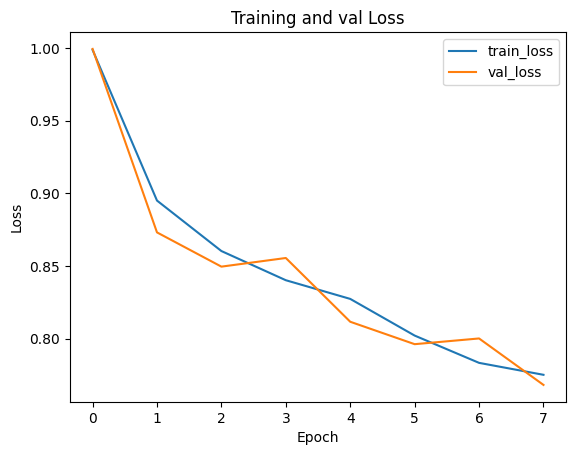

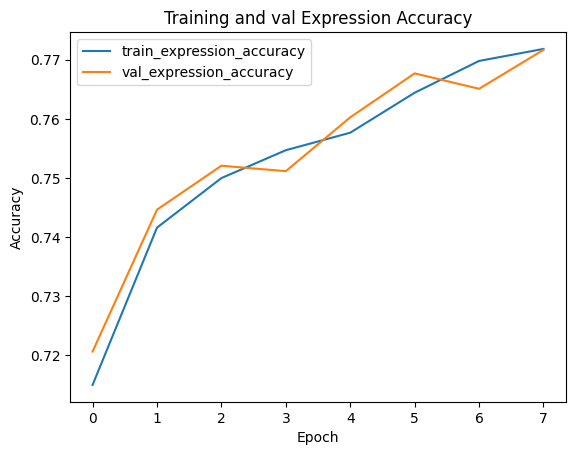

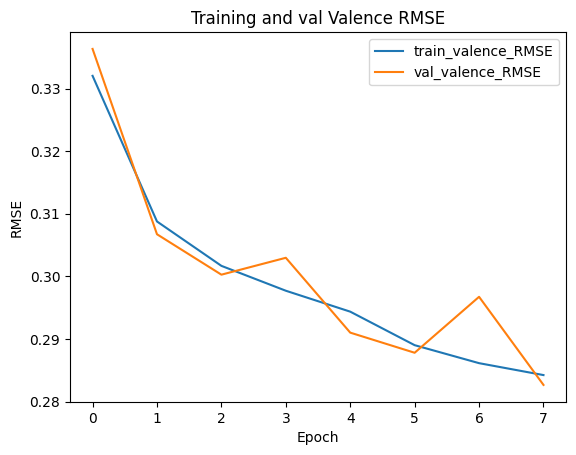

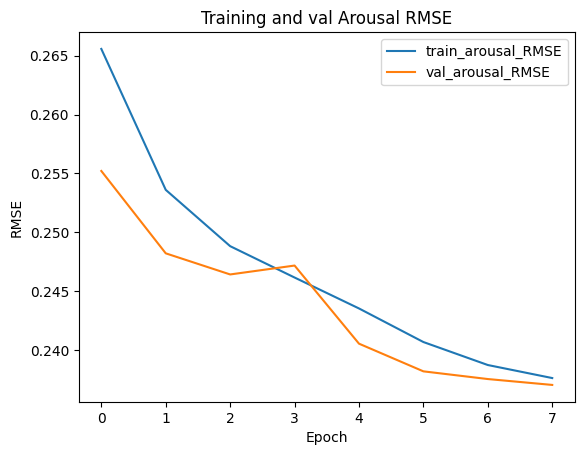

In [ ]:
# Training Graphs

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

plt.figure()
plt.plot(train_exp_accuracy_list, label="train_expression_accuracy")
plt.plot(val_exp_accuracy_list, label="val_expression_accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and val Expression Accuracy')

plt.figure()
plt.plot(train_val_rmse_list, label='train_valence_RMSE')
plt.plot(val_val_rmse_list, label="val_valence_RMSE")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and val Valence RMSE')

plt.figure()
plt.plot(train_aro_rmse_list, label="train_arousal_RMSE")
plt.plot(val_aro_rmse_list, label="val_arousal_RMSE")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and val Arousal RMSE')